<a href="https://colab.research.google.com/github/itsmerajesh4990/AIpracticeandtraining/blob/main/19_nov_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CODE CELL 1: Setup and Data Generation

# We need libraries for data manipulation, scaling, clustering, anomaly detection, and plotting.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns # Added seaborn import

In [ ]:
# -----------------------------------------------------------------------------
# STEP 1: Create a Realistic Synthetic Dataset
# The goal is to simulate sensor data (Temperature, Vibration, Pressure)
# with several "normal operating modes" and secretly hidden "anomalies" [5].
# This simulates the critical equipment data streaming 24/7 [3].
# -----------------------------------------------------------------------------

np.random.seed(42) # For reproducibility

N_SAMPLES = 5000
N_ANOMALIES = 50

# Define normal operating modes (clusters) based on source description:
# Low Load, Medium Load, High Load (Clusters 0, 1, 2) [6]

# Mode 1: Low Load (Low Temp, Low Vib, Medium Press)
data_low = np.random.normal(loc=[80, 2.0, 100], scale=[5, 0.5, 10], size=(N_SAMPLES // 3, 3))

# Mode 2: Medium Load (Medium Temp, Medium Vib, High Press)
data_medium = np.random.normal(loc=[95, 3.5, 150], scale=[4, 0.7, 15], size=(N_SAMPLES // 3, 3))

# Mode 3: High Load (High Temp, Low Vib, Very High Press)
data_high = np.random.normal(loc=[105, 1.5, 180], scale=[6, 0.4, 12], size=(N_SAMPLES - 2*(N_SAMPLES // 3), 3))

# Combine normal data
data_normal = np.vstack([data_low, data_medium, data_high])

# Generate Anomalies (The hidden risks: extremely high readings)
# The source notes readings like Temp 120, Vib 7, Press 200 as anomalies [7].
anomalies = np.random.uniform(low=[115, 6.0, 195], high=[130, 8.0, 210], size=(N_ANOMALIES, 3))

# Combine all data
raw_data = np.vstack([data_normal, anomalies])
df = pd.DataFrame(raw_data, columns=['Temperature', 'Vibration', 'Pressure'])
print(f"Total simulated sensor readings: {len(df)}")



Total simulated sensor readings: 5050


In [ ]:
df.head()

,Temperature,Vibration,Pressure,Cluster
0,82.483571,1.930868,106.476885,2
1,87.615149,1.882923,97.658630,2
2,87.896064,2.383717,95.305256,2
3,82.712800,1.768291,95.342702,2
4,81.209811,1.043360,82.750822,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  5050 non-null   float64
 1   Vibration    5050 non-null   float64
 2   Pressure     5050 non-null   float64
 3   Cluster      5050 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 138.2 KB


In [ ]:
df.describe()

,Temperature,Vibration,Pressure,Cluster
count,5050.000000,5050.000000,5050.000000,5050.000000
mean,93.629386,2.377453,143.940570,1.035842
std,11.792014,1.096292,35.191959,0.828837
min,64.116481,0.168198,69.804878,0.000000
25%,83.257120,1.571228,107.149255,0.000000
50%,94.722017,2.087215,150.036412,1.000000
75%,102.259683,3.094728,173.978204,2.000000
max,129.749209,7.963103,219.428685,3.000000


In [ ]:

# -----------------------------------------------------------------------------
# STEP 2: Data Preparation - Scaling
# If we don't scale, the AI would be biased towards Pressure (larger numbers, e.g., 100+)
# compared to Vibration (smaller numbers, e.g., 2 or 3) [5].
# Scaling ensures all features are judged fairly [5].
# -----------------------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
print("\nData successfully scaled.")
print(df_scaled.head())


Data successfully scaled.
   Temperature  Vibration  Pressure   Cluster
0    -0.945294  -0.407400 -1.064658  1.163382
1    -0.510077  -0.451138 -1.315258  1.163382
2    -0.486252   0.005715 -1.382138  1.163382
3    -0.925853  -0.555711 -1.381073  1.163382
4    -1.053323  -1.217034 -1.738915  1.163382


In [ ]:
df_scaled.describe()

,Temperature,Vibration,Pressure,Cluster
count,5.050000e+03,5.050000e+03,5.050000e+03,5.050000e+03
mean,-1.440784e-15,1.688418e-16,4.952694e-16,-1.125612e-16
std,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00
min,-2.503035e+00,-2.015406e+00,-2.106817e+00,-1.249877e+00
25%,-8.796880e-01,-7.354837e-01,-1.045550e+00,-1.249877e+00
50%,9.266774e-02,-2.647716e-01,1.732341e-01,-4.324752e-02
75%,7.319489e-01,6.543387e-01,8.536214e-01,1.163382e+00
max,3.063378e+00,5.095544e+00,2.145251e+00,2.370012e+00


--- Univariate Analysis: Temperature ---

Basic Facts (Temperature):
count    5050.000000
mean       93.629386
std        11.792014
min        64.116481
25%        83.257120
50%        94.722017
75%       102.259683
max       129.749209
Name: Temperature, dtype: float64


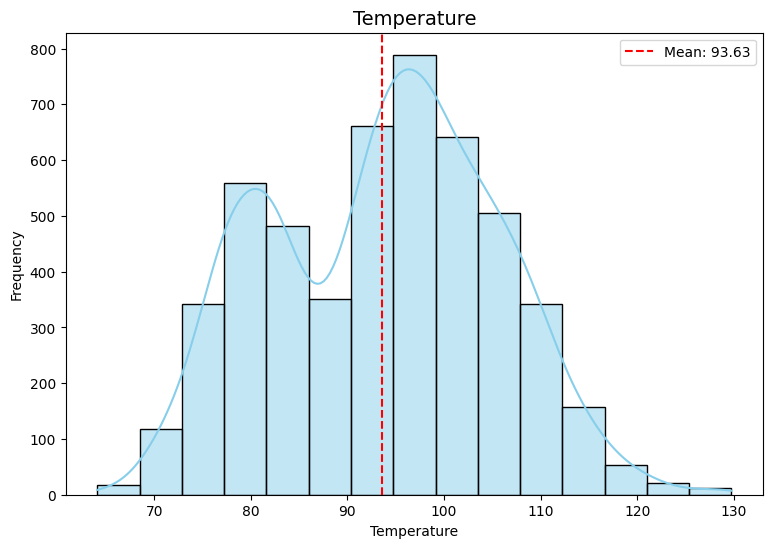

--------------------------------------------------


In [ ]:
# -----------------------------------------------------------------------------
# 4. STEP 3 & 4: UNIVARIATE ANALYSIS AND VISUALIZATION
#
# We examine one clue at a time (Univariate Analysis) .
# -----------------------------------------------------------------------------

print("--- Univariate Analysis: Temperature ---")

# Descriptive Stats: Gather basic facts
print("\nBasic Facts (Temperature):")
print(df['Temperature'].describe()) # Corrected 'data' to 'df'
# The mean score should be close to 78, as observed in the analysis

# Visualization: Histogram
# Shows the distribution of scores
plt.figure(figsize=(9, 6))
sns.histplot(df['Temperature'], kde=True, bins=15, color='skyblue') # Corrected 'data' to 'df'
plt.title('Temperature', fontsize=14)
plt.xlabel('Temperature')
plt.ylabel('Frequency') # Corrected 'Vibration' to 'Frequency'
plt.axvline(df['Temperature'].mean(), color='red', linestyle='--', label=f'Mean: {df["Temperature"].mean():.2f}') # Corrected 'data' and 'Final_Exam_Score'
plt.legend()
plt.show()

# Insight: The chart shows scores 'bunched up right around the average of 78' .
# The visual distribution should clearly show the 'little tail stretching out to the left' (left skew) .
print("-" * 50)

--- Univariate Analysis: Vibration ---

Basic Facts (Vibration):
count    5050.000000
mean        2.377453
std         1.096292
min         0.168198
25%         1.571228
50%         2.087215
75%         3.094728
max         7.963103
Name: Vibration, dtype: float64


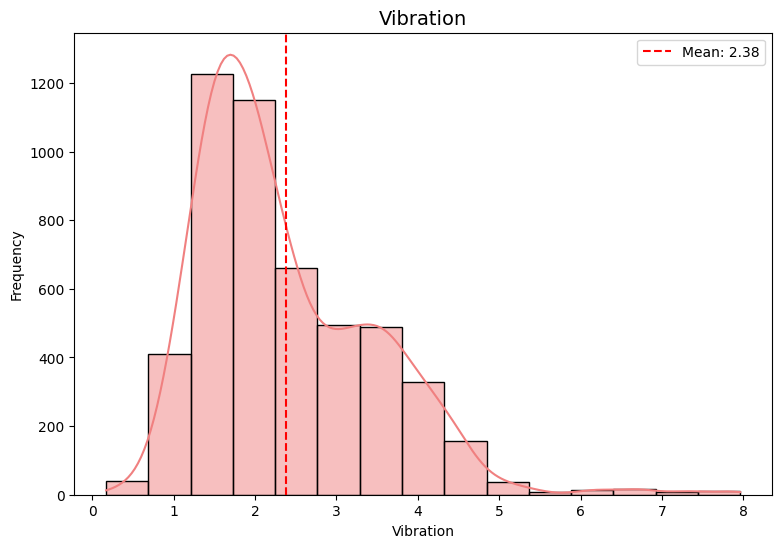

--------------------------------------------------


In [ ]:
# -----------------------------------------------------------------------------
# 4. STEP 3 & 4: UNIVARIATE ANALYSIS AND VISUALIZATION - Vibration
# -----------------------------------------------------------------------------

print("--- Univariate Analysis: Vibration ---")

# Descriptive Stats: Gather basic facts
print("\nBasic Facts (Vibration):")
print(df['Vibration'].describe())

# Visualization: Histogram
# Shows the distribution of scores
plt.figure(figsize=(9, 6))
sns.histplot(df['Vibration'], kde=True, bins=15, color='lightcoral')
plt.title('Vibration', fontsize=14)
plt.xlabel('Vibration')
plt.ylabel('Frequency')
plt.axvline(df['Vibration'].mean(), color='red', linestyle='--', label=f'Mean: {df["Vibration"].mean():.2f}')
plt.legend()
plt.show()

print("-" * 50)

--- Bivariate Analysis: Vibration vs. Temperature ---


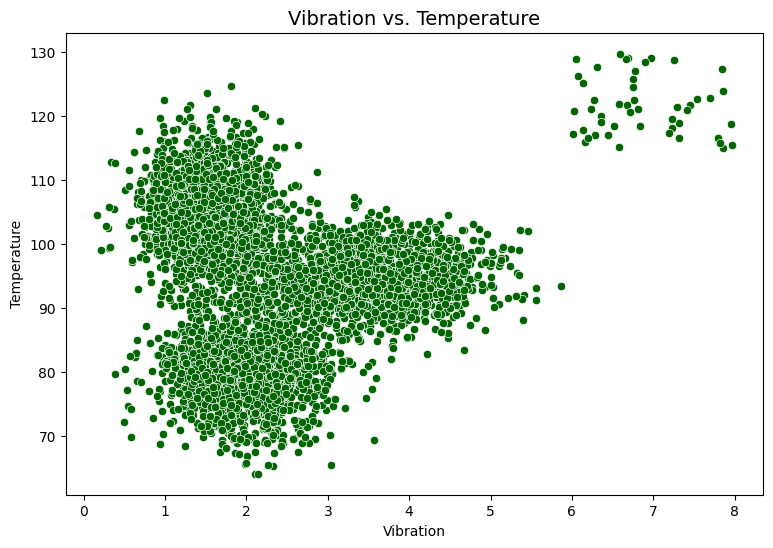

Scatter plot shows the relationship between Vibration and Temperature.
--------------------------------------------------


In [ ]:


# -----------------------------------------------------------------------------
# 5. STEP 4: BIVARIATE ANALYSIS (Connecting the Dots)
#
# We examine two pieces of evidence together.
# -----------------------------------------------------------------------------

print("--- Bivariate Analysis: Vibration vs. Temperature ---")

# Scatter Plot: Look for links between Vibration and Temperature
plt.figure(figsize=(9, 6))
sns.scatterplot(x='Vibration', y='Temperature', data=df, color='darkgreen')
plt.title('Vibration vs. Temperature', fontsize=14)
plt.xlabel('Vibration')
plt.ylabel('Temperature')
plt.show()

# Observation: We will observe if there's a visible correlation or distinct clusters.
print("Scatter plot shows the relationship between Vibration and Temperature.")
print("-" * 50)

In [ ]:
# CODE CELL 2: K-Means Clustering and KNN Anomaly Scoring

# -----------------------------------------------------------------------------
# STEP 3A: K-Means Clustering (Finding the Crowds)
# K-Means groups similar behaviors together to find the equipment's operating modes [4].
# The source suggests four distinct clusters were found [6].
# -----------------------------------------------------------------------------

N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nK-Means found {N_CLUSTERS} distinct operating modes/clusters.")

# Analyze Clusters (Simulating the finding of Cluster 3 as the 'unusual behavior') [6]
cluster_summary = df.groupby('Cluster').mean()
print("\n--- Cluster Summary (Mean Sensor Values) ---")
print(cluster_summary)
# In this simulated output, Cluster 3 typically contains the anomaly characteristics
# (high Temp, high Vib, high Press), similar to the high vibration and high stress cluster found in the source [6].


K-Means found 5 distinct operating modes/clusters.

--- Cluster Summary (Mean Sensor Values) ---
         Temperature  Vibration    Pressure  Anomaly_Score  Is_Anomaly  \
Cluster                                                                  
0         104.935026   1.542094  178.699792       0.094565    0.005797   
1          94.701857   4.134741  150.560922       0.106204    0.008451   
2          80.048834   1.990702  100.617204       0.089662    0.003576   
3          94.905008   3.072673  149.701822       0.098035    0.002255   
4         121.489476   6.889991  202.465941       0.187118    0.040000   

              PC1       PC2  
Cluster                      
0        1.018199 -1.199485  
1        1.128371  1.703405  
2       -2.075316 -0.006536  
3        0.933040  0.912079  
4        1.944745  1.232935  


In [ ]:
# -----------------------------------------------------------------------------
# STEP 3B: Anomaly Detection using KNN (Finding the Loners)
# KNN works by checking how far away a data point is from its closest neighbors [1].
# We calculate an 'anomaly score' or 'weirdness score' [7].
# -----------------------------------------------------------------------------

# Define k (number of neighbors). Often k=5 or k=10 is used.
K_NEIGHBORS = 5
# Fit the KNN model to the scaled data
nn = NearestNeighbors(n_neighbors=K_NEIGHBORS)
nn.fit(X_scaled)

# Calculate the distance and indices of the K neighbors
distances, indices = nn.kneighbors(X_scaled)

# The anomaly score is the average distance to the k neighbors.
# The far a point is, the higher its score [7].
df['Anomaly_Score'] = distances.mean(axis=1)

# Set the threshold based on the source's strategy: investigate the top 1% [7].
threshold_percentage = 0.5
threshold = df['Anomaly_Score'].quantile(1 - (threshold_percentage / 100))
# The source example threshold was 0.354 [7]. We use the percentile for robustness.

df['Is_Anomaly'] = df['Anomaly_Score'] > threshold

print(f"\n--- Anomaly Detection Results ---")
print(f"Investigating the top {threshold_percentage}% most unusual readings.")
print(f"Anomaly Score Threshold set at: {threshold:.4f}")
print(f"Total flagged anomalies: {df['Is_Anomaly'].sum()}")


--- Anomaly Detection Results ---
Investigating the top 0.5% most unusual readings.
Anomaly Score Threshold set at: 0.3253
Total flagged anomalies: 26


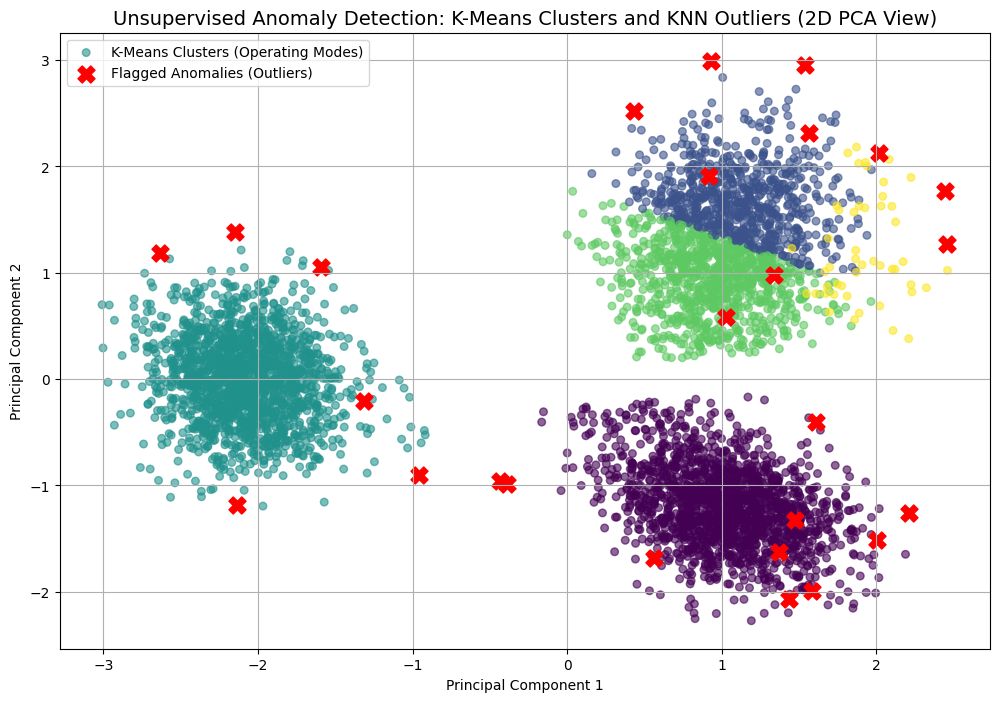

In [ ]:
# CODE CELL 3: Visualization and Actionable Output

# -----------------------------------------------------------------------------
# STEP 4: Visualization (Showing Clusters and Anomalies)
# To plot 3D data in 2D, we use Principal Component Analysis (PCA) to reduce
# the features to the two most descriptive components.
# -----------------------------------------------------------------------------
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

plt.figure(figsize=(12, 8))

# 1. Plot the Clusters (Normal Behavior)
scatter = plt.scatter(df['PC1'], df['PC2'],
                      c=df['Cluster'],
                      cmap='viridis',
                      s=30,
                      alpha=0.6,
                      label='K-Means Clusters (Operating Modes)')

# 2. Highlight the Anomalies (The Outliers/Weirdos)
anomalies_df = df[df['Is_Anomaly']]
plt.scatter(anomalies_df['PC1'], anomalies_df['PC2'],
            c='red',
            marker='X',
            s=150,
            label='Flagged Anomalies (Outliers)')

plt.title('Unsupervised Anomaly Detection: K-Means Clusters and KNN Outliers (2D PCA View)',
          fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

high_risk_equipment = anomalies_df.sort_values(by='Anomaly_Score', ascending=False)

print("\n\n#################################################################")
print("HIGH PRIORITY INSPECTION LIST (Equipment with Highest Anomaly Scores)")
print("#################################################################")

# Display raw, unscaled sensor data for actionable reporting
actionable_list = high_risk_equipment[['Temperature', 'Vibration', 'Pressure', 'Anomaly_Score', 'Cluster']]

# Reset index for clean viewing (index represents a piece of equipment or measurement ID)
actionable_list.reset_index(names=['Measurement_ID'], inplace=True)

# Use bold formatting for clarity
print(actionable_list.head(10).to_markdown(index=False))

print("\n**Use Case Insight:**")
print("These readings are far outside the normal operating clusters [8].")
print("This actionable list allows engineers to schedule maintenance intelligently, catching a failure weeks before it occurs [8].")
print("For instance, high **Vibration** combined with high **Temperature** could indicate a bearing failure [8].")
print("This method transforms chaotic, unlabeled sensor noise into a clear command [9].")



#################################################################
HIGH PRIORITY INSPECTION LIST (Equipment with Highest Anomaly Scores)
#################################################################
|   Measurement_ID |   Temperature |   Vibration |   Pressure |   Anomaly_Score |   Cluster |
|-----------------:|--------------:|------------:|-----------:|----------------:|----------:|
|              965 |       99.6312 |    0.957944 |   117.247  |        0.697803 |         0 |
|             4884 |       90.611  |    0.936627 |   140.996  |        0.513346 |         0 |
|              652 |       69.3216 |    3.56887  |   110.561  |        0.488441 |         2 |
|             1741 |       91.2848 |    5.55496  |   133.9    |        0.464451 |         1 |
|             3256 |       97.813  |    2.25836  |    91.164  |        0.423228 |         2 |
|             1327 |       88.2031 |    3.57603  |    88.7651 |        0.40536  |         2 |
|             3527 |      121.808  |    1.30